In [238]:
import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.dates as mdates
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

import itertools
from itertools import product                    # some useful functions
from tqdm import tqdm_notebook

from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima_model import ARIMA


import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

In [239]:
df = pd.read_csv('../data/day.csv')
df = df.set_index(pd.DatetimeIndex(df['dteday']))

In [240]:
# Add columns with year, month, and weekday name
df['Year'] = df.index.year
df['Month'] = df.index.month
df['Weekday Name'] = df.index.weekday_name

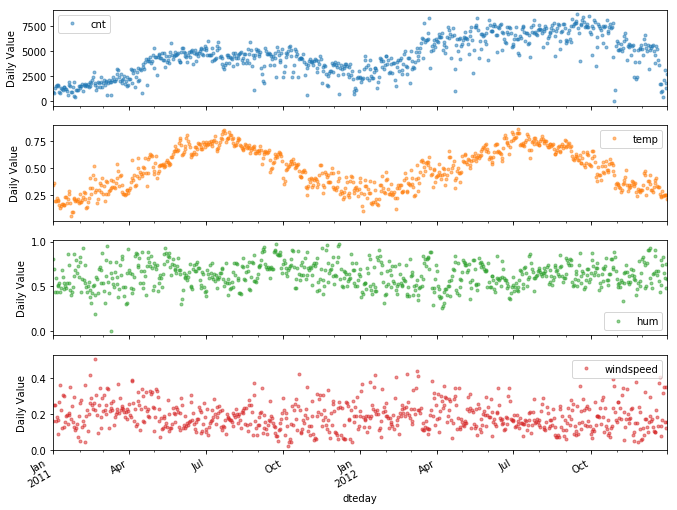

In [241]:
cols_plot = ['cnt','temp', 'hum', 'windspeed']
axes = df[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_ylabel('Daily Value')

In [242]:
# Specify the data columns we want to include (i.e. exclude Year, Month, Weekday Name)
data_columns = ['temp', 'hum', 'windspeed', 'cnt']
# Resample to weekly frequency, aggregating with mean
df_weekly_mean = df[data_columns].resample('W').mean()
# weekly rolling mean
df_weekly_rolling = df[data_columns].rolling(7, center=True).mean()

In [243]:
# CROSS VALIDATE ARIMA
ts_cv = TimeSeriesSplit(n_splits=10)
x = df['cnt'].copy().astype(float)

result = list()
p_max = 5
d_max = 2
q_max = 5

for p, d, q in list(itertools.product(*[list(range(p_max+1)), list(range(d_max+1)), list(range(q_max+1))])):
    
    if p==d==q == 0:
        continue
        
    intermediateResult = list()

    for train_index, test_index in ts_cv.split(x):
        # ARIMA model might throw e.g. invertability error with certain parameters
        # If this is the case, skip the parameter combination
        try:
            x_train, x_test = x[train_index], x[test_index]
            model = ARIMA(x_train, order=(p,d,q))
            model_fitted = model.fit(disp=0)
            prediction = model_fitted.forecast(len(x_test))[0]
            difference = np.nansum(np.dstack((prediction,-x_test)), 2)
            differences_no_nans = difference[~np.isnan(difference)]
            squared_error = (differences_no_nans)**2
            mse = np.mean(squared_error)

            #print('{}: MSE {} and Test Set Length {}'.format(i, mse, len(y_test)))
            intermediateResult += [mse]
        except (ValueError, np.linalg.LinAlgError) as e:
            continue

    mse_cv = np.mean(intermediateResult)
    result += [((p, d, q), mse_cv)]

In [244]:
best = min(result, key = lambda x: x[1])[0]

In [245]:
min(result, key = lambda x: x[1])

((5, 0, 4), 1233382.0387227545)

In [246]:
fitted_arima = ARIMA(df['cnt'].astype(float), order=best).fit(disp=0)

In [247]:
# CROSS VALIDATE MOVING AVERAGE
ts_cv = TimeSeriesSplit(n_splits=10)
x = df['cnt'].copy().astype(float)

result = list()
t_max = 700

for t in range(1,t_max):

    intermediateResult = list()

    for train_index, test_index in ts_cv.split(x):

        x_train, x_test = x[train_index], x[test_index]
        prediction = x_train.rolling(t, center=True).mean()[-len(test_index):]
        difference = np.nansum(np.dstack((prediction,-x_test)), 2)
        differences_no_nans = difference[~np.isnan(difference)]
        squared_error = (differences_no_nans)**2
        mse = np.mean(squared_error)

        #print('{}: MSE {} and Test Set Length {}'.format(i, mse, len(y_test)))
        intermediateResult += [mse]

    mse_cv = np.mean(intermediateResult)
    result += [(t, mse_cv)]

In [248]:
min(result, key = lambda x: x[1])

(2, 3639484.0446969694)

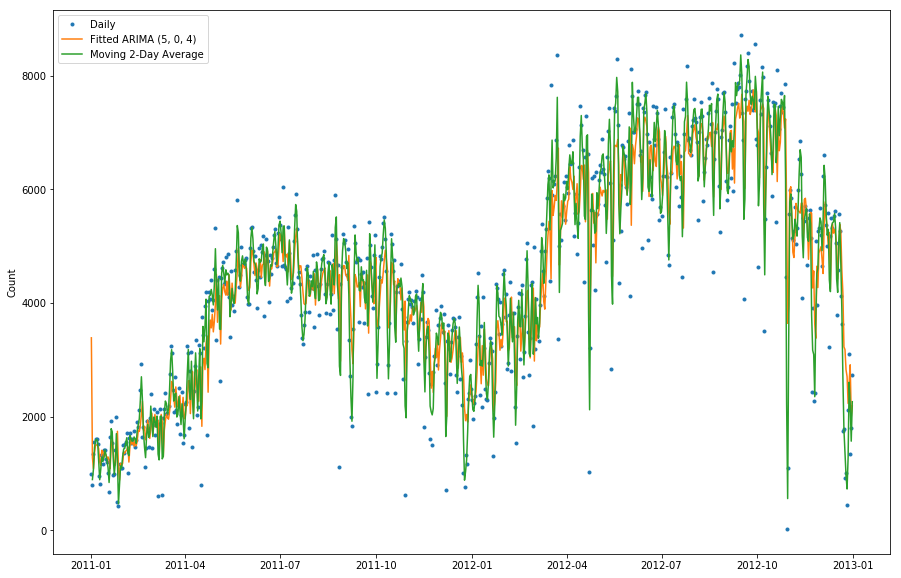

In [249]:
t=2
# plot
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(df.loc[:, 'cnt'],
marker='.', linestyle='', linewidth=0.5, label='Daily')
ax.plot(fitted_arima.predict(),
marker='', linestyle='-', label='Fitted ARIMA {}'.format(best))
ax.plot(df.loc[:, 'cnt'].rolling(t, center=True).mean(),
marker='', linestyle='-', label='Moving {}-Day Average'.format(t))
ax.set_ylabel('Count')
ax.legend();
plt.savefig('../output/plots/weekly_averages.png')

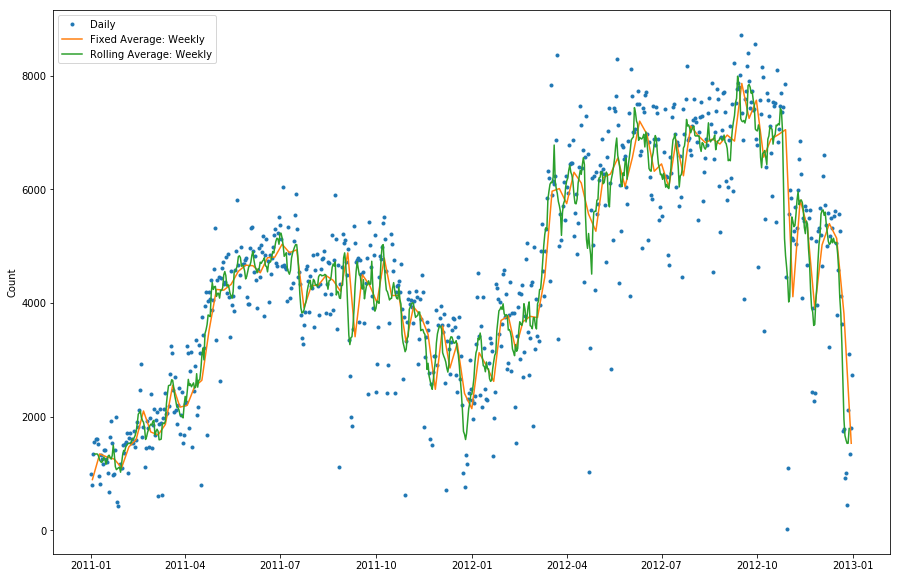

In [250]:
# plot moving averages
# Start and end of the date range to extract
start, end = '2011-01-01', '2012-12-31'
# Plot daily, weekly resampled, and 7-day rolling mean time series together
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(df.loc[start:end, 'cnt'],
marker='.', linestyle='', linewidth=0.5, label='Daily')
ax.plot(df_weekly_mean.loc[start:end, 'cnt'],
marker='', markersize=8, linestyle='-', label='Fixed Average: Weekly')
ax.plot(df_weekly_rolling.loc[start:end, 'cnt'],
marker='', linestyle='-', label='Rolling Average: Weekly')
ax.set_ylabel('Count')
ax.legend();
plt.savefig('../output/plots/weekly_averages.png')

In [68]:
####### THE CODE BELOW DOESN'T WORK ###########

In [79]:
# auto selects arima using aic - doesn't work for me
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

AttributeError: type object 'pmdarima.arima._arima.array' has no attribute '__reduce_cython__'

In [89]:
# tried something  - not sure - has seasonaity 

# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [91]:
# does parameter search with sarima - not sure

warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue